In [1]:
import sys
sys.path.append('/home/stratis/probabilistic-rl-thesis/code')

import os
import pathlib
import pickle

from TabularAgents import QLearningAgent, BayesianQAgent, PSRLAgent, MomentMatchingAgent, UbeNoUnrollAgent
from EnvironmentsPS import DeepSea, WideNarrow, GridWall, PriorMDP

from tqdm import tqdm_notebook as tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from copy import deepcopy

from utils import solve_tabular_continuing_PI

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

In [2]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

save_loc = 'download_figures/posterior_accuracies/'
!mkdir download_figures/posterior_accuracies

mkdir: cannot create directory ‘download_figures/posterior_accuracies’: File exists


In [3]:
def run_offline_experiment(environment, pi, num_offline_frames, seed, num_oracle_iter):
    
    np.random.seed(seed)
    
    # Save current environment state
    s0, t0 = environment.s, environment.t
    
    # Initial state
    environment.reset()
    s, t = 0, 0
    
    states, actions, rewards, states_ = [], [], [], []
    
    for n in range(num_offline_frames):
        
        a = pi[s]
        
        # Step environment
        s_, r, t, done = environment.step(a)
        
        states.append(s)
        actions.append(a)
        rewards.append(r)
        states_.append(s_)
        
        s = s_
        
    # Initial state
    environment.reset()
    s, t = 0, 0
    
    agent_sars_ = np.array(states), np.array(actions), np.array(rewards), np.array(states_)
    
    oracle_sars_ = run_oracle_experiment(environment,
                                         seed,
                                         gamma=agent.gamma, 
                                         num_iter=num_oracle_iter,
                                         num_episodes=1,
                                         num_frames_per_episode=num_offline_frames-1)
    
    offline_regret = np.sum((oracle_sars_[2] - agent_sars_[2]))
    
    # Restore environment state
    environment.s, environment.t = s0, t0
    
    return [offline_regret, oracle_sars_, agent_sars_]

In [4]:
def run_experiment(environment,
                   agent,
                   seed,
                   num_episodes,
                   num_frames_per_episode,
                   save_every,
                   num_offline_frames,
                   num_oracle_iter,
                   max_buffer_length=0):
    
    np.random.seed(seed)
    
    # Initial state
    environment.reset()
    s, t = 0, 0

    # Save location for agent
    save_loc = '/big/tabular_results/toy-deepsea/{}/{}/seed-{}/'.format(environment.get_name(),
                                                                        agent.get_name(),
                                                                        seed)
    pathlib.Path(save_loc).mkdir(parents=True, exist_ok=True)
    
    agent_copies = []
    
    for n in range(num_episodes):
        for i in tqdm(range(num_frames_per_episode + 1)):
            
            # Take action
            a = agent.take_action(s, t)

            # Step environment
            s_, r, t, done = environment.step(a)

            # Update agent
            agent.observe([t, s, a, r, s_])
            agent.update_after_step(max_buffer_length)

            # Update current state (for agent)
            s = s_
            
            if i % save_every == 0:
                agent_copies.append(deepcopy(agent))
                
                result = run_offline_experiment(environment,
                                                agent.get_greedy_policy(),
                                                num_offline_frames,
                                                np.random.randint(low=0, high=int(1e6)),
                                                num_oracle_iter)

                agent.offline_regret = result[0]
                agent.agent_sars_ = result[1]
                agent.oracle_sars_ = result[2]

                agent.save_copy(save_loc, '{}_{}'.format(n, i))
                
    return agent_copies

In [5]:
def run_oracle_experiment(environment, seed, gamma, num_iter, num_episodes, num_frames_per_episode):
    
    np.random.seed(seed * 10)
    
    # Initial state
    environment.reset()
    s, t = 0, 0
    
    pi, Q = environment.get_optimal_policy(gamma=gamma, num_iter=num_iter)

    # Save location for agent
    save_loc = '/big/tabular_results/{}/{}/'.format(environment.get_name(), agent.get_name())
    pathlib.Path(save_loc).mkdir(parents=True, exist_ok=True)
    
    states, actions, rewards, states_ = [], [], [], []
    
    for n in range(num_episodes):
        for i in range(num_frames_per_episode + 1):
            
            # Take action
            a = pi[s]

            # Step environment
            s_, r, t, done = environment.step(a)

            states.append(s)
            actions.append(a)
            rewards.append(r)
            states_.append(s_)

            # Update current state (for agent)
            s = s_
        
    return np.array(states), np.array(actions), np.array(rewards), np.array(states_)

In [6]:
def load_agent(environment, agent, seed, episode, frame):

    # Load location
    load_name = '/big/tabular_results/toy-deepsea/{}/{}/seed-{}/chkpt_{}_{}'.format(environment.get_name(),
                                                                                    agent.get_name(),
                                                                                    seed,
                                                                                    episode,
                                                                                    frame)
    
    # Load the agent
    fhandle = open(load_name, 'rb')
    agent = pickle.load(fhandle)
    
    return agent

In [7]:
save_every = 100
N = 1
W = 4

max_frames = 5000
save_times = max_frames // save_every

# QL

In [85]:
# for N in tqdm([1]):
#     for W in tqdm([4]):
#         for seed in tqdm(range(10)):
#             # Environment constants
#             rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
#             env_params = {'N'          : N,
#                           'W'          : W,
#                           'episodic'   : False,
#                           'rew_params' : rew_params}

#             # Define environment
#             environment = WideNarrow(env_params)
#             environment.reset()

#             # Agent constants
#             agent_params = {'gamma'            : 0.9,
#                             'dither_mode'      : 'epsilon-greedy',
#                             'dither_param'     : 0.2,
#                             'lr'               : 0.1,
#                             'Q0'               : 0.0,
#                             'T'                : float('inf'),
#                             'anneal_timescale' : float('inf'),
#                             'sa_list'          : environment.sa_list()}

#             # Define agent
#             agent = QLearningAgent(agent_params)

#             # Run experiment
#             agent_copies = run_experiment(environment,
#                                           agent,
#                                           seed=seed,
#                                           num_episodes=1,
#                                           num_frames_per_episode=max_frames,
#                                           num_offline_frames=1000,
#                                           num_oracle_iter=10,
#                                           save_every=save_every)

In [172]:
# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : 1,
              'W'          : 4,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

In [173]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=200)

In [174]:
# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'dither_mode'      : 'epsilon-greedy',
                'dither_param'     : 0.2,
                'lr'               : 0.1,
                'Q0'               : 0.0,
                'T'                : float('inf'),
                'anneal_timescale' : float('inf'),
                'sa_list'          : environment.sa_list()}

num_s = len(set([s for (s, a) in environment.sa_list()]))
num_a = len(set([a for (s, a) in environment.sa_list()]))

means, stds = np.zeros((save_times + 1, num_s, num_a)), np.zeros((save_times + 1, num_s, num_a))

sa_dict = {}
for (s, a) in environment.sa_list():
    if s in sa_dict: 
        sa_dict[s].append(a)
    else:
        sa_dict[s] = [a]

# Define agent
agent = QLearningAgent(agent_params)

for t, frame in enumerate(np.arange(0, max_frames + 1, save_every)):
    
    # Define agent
    agent_ = load_agent(environment, QLearningAgent(agent_params), seed=1, episode=0, frame=frame)
    
    for s in range(2):
        
        for a in sa_dict[s]:
            means[t, s, a] = agent_.Q[s][a]

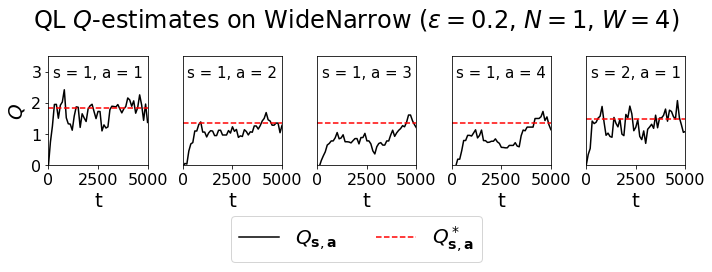

In [176]:
fig = plt.figure(figsize=(10, 3.8))

actions = ['left', 'right']
leg_names = ['$Q_{\mathbf{s}, \mathbf{a}}$', '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 2
s, a = 0, 0

for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='black')
        
        leg[1], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        
        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
            plt.yticks([0, 1, 2, 3])
        
        plt.gca().text(2500, 2.8, r's = {}, a = {}'.format(s + 1, a + 1),
                       fontsize=15, horizontalalignment='center')
            
        plt.ylim([0, 3.5])
        plt.xticks([0, 2500, 5000])
        plt.xlim([0, 5000])
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('QL $Q$-estimates on WideNarrow ($\epsilon = 0.2$, $N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.8, bottom=0.4)
plt.savefig(save_loc + 'ql-posterior-accuracy-widenarrow-4.pdf', bbox_inches='tight')
plt.show()

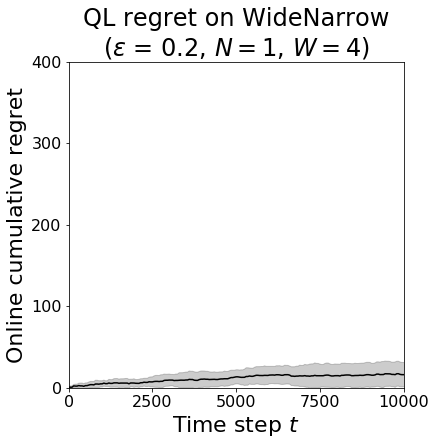

In [90]:
# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'dither_mode'      : 'epsilon-greedy',
                'dither_param'     : 0.2,
                'lr'               : 0.1,
                'Q0'               : 0.0,
                'T'                : float('inf'),
                'anneal_timescale' : float('inf'),
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = QLearningAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=400)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=400)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(np.arange(len(means)) * save_times, means, color='k')
plt.fill_between(np.arange(len(means)) * save_times, means - stds, means + stds, color='k', alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('QL regret on WideNarrow\n($\epsilon$ = 0.2, $N = 1$, $W = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 10000])
plt.gca().set_ylim(bottom=0, top=400)
plt.savefig(save_loc + 'ql-cumulative-regret-widenarrow-4.pdf', bbox_inches='tight')
plt.show()

# BQL

In [148]:
# for N in tqdm([1]):
#     for W in tqdm([4]):
#         for seed in tqdm(range(10)):
#             # Environment constants
#             rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
#             env_params = {'N'          : N,
#                           'W'          : W,
#                           'episodic'   : False,
#                           'rew_params' : rew_params}

#             # Define environment
#             environment = WideNarrow(env_params)
#             environment.reset()

#             # Agent constants
#             agent_params = {'gamma'               : 0.9,
#                             'mu0'                 : 0.0,
#                             'lamda'               : 1.0,
#                             'alpha'               : 2.0,
#                             'beta'                : 2.0,
#                             'T'                   : float('inf'),
#                             'num_mixture_samples' : 1000,
#                             'sa_list'             : environment.sa_list()}

#             # Define agent
#             agent = BayesianQAgent(agent_params)

#             # Run experiment
#             agent_copies = run_experiment(environment,
#                                           agent,
#                                           seed=seed,
#                                           num_episodes=1,
#                                           num_frames_per_episode=max_frames,
#                                           num_offline_frames=1000,
#                                           num_oracle_iter=10,
#                                           save_every=save_every)

In [201]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [202]:
# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 2.0,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}

num_s = len(set([s for (s, a) in environment.sa_list()]))
num_a = len(set([a for (s, a) in environment.sa_list()]))

means, stds = np.zeros((save_times + 1, num_s, num_a)), np.zeros((save_times + 1, num_s, num_a))

for t, frame in enumerate(np.arange(0, max_frames + 1, save_every)):
    
    # Define agent
    agent_ = load_agent(environment, BayesianQAgent(agent_params), seed=seed, episode=0, frame=frame)
    
    for s in range(2):
        
        for a in sa_dict[s]:
            
            mu, lamda, alpha, beta = agent_.Qpost[s][a]
            var = beta / (lamda * (alpha - 1))
            
            means[t, s, a] = mu
            stds[t, s, a] = var**0.5

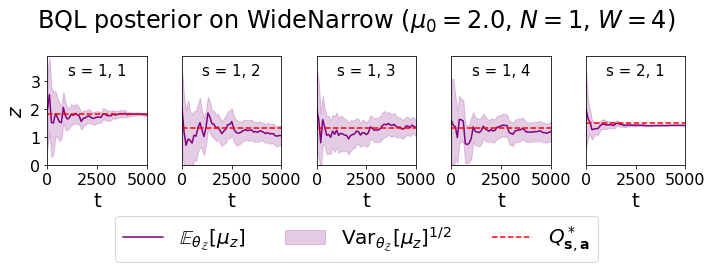

In [203]:
fig = plt.figure(figsize=(10, 3.8))

actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{Z}}}[\mu_z]$',
             'Var$_{\\theta_{\mathcal{Z}}}[\mu_z]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='purple')
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color='purple', alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
            
        plt.ylim([0, 3.9])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2500, 5000])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$z$', fontsize=20)
            plt.yticks([0, 1, 2, 3])
        
        plt.gca().text(2500, 3.2, r's = {}, {}'.format(s + 1, a + 1),
                       fontsize=15, horizontalalignment='center')
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('BQL posterior on WideNarrow ($\mu_0 = 2.0$, $N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.8, bottom=0.4)
plt.savefig(save_loc + 'bql-posterior-accuracy-widenarrow-4-2_0.pdf', bbox_inches='tight')
plt.show()

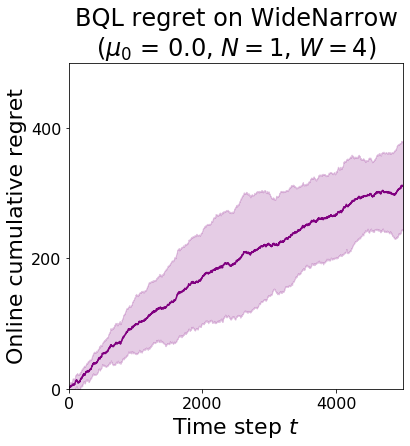

In [204]:
color = 'purple'

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = BayesianQAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=max_frames)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=max_frames)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('BQL regret on WideNarrow\n($\mu_0$ = 0.0, $N = 1$, $W = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 5000])
plt.gca().set_ylim(bottom=0, top=500)
plt.savefig(save_loc + 'bql-cumulative-regret-widenarrow-4-0_0.pdf', bbox_inches='tight')
plt.show()

# PSRL

In [96]:
# for N in tqdm([1]):
#     for W in tqdm([4]):
#         for seed in tqdm(range(10)):
#             # Environment constants
#             rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
#             env_params = {'N'          : N,
#                           'W'          : W,
#                           'episodic'   : False,
#                           'rew_params' : rew_params}

#             # Define environment
#             environment = WideNarrow(env_params)
#             environment.reset()

#             # Agent constants
#             agent_params = {'gamma'            : 0.9,
#                             'kappa'            : 1.0,
#                             'mu0'              : 0.0,
#                             'lamda'            : 1.0,
#                             'alpha'            : 2.0,
#                             'beta'             : 2.0,
#                             'num_pi_iter'      : 100,
#                             'T'                : float('inf'),
#                             'num_dyn_samples'  : 100,
#                             'sa_list'          : environment.sa_list()}

#             # Define agent
#             agent = PSRLAgent(agent_params)

#             # Run experiment
#             agent_copies = run_experiment(environment,
#                                           agent,
#                                           seed=seed,
#                                           num_episodes=1,
#                                           num_frames_per_episode=max_frames+1,
#                                           num_offline_frames=10,
#                                           num_oracle_iter=100,
#                                           max_buffer_length=3,
#                                           save_every=save_every)

In [189]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [190]:
means = []

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

for frame in np.arange(0, max_frames, save_times):
    
    agent_ = load_agent(environment, PSRLAgent(agent_params), seed=0, episode=0, frame=frame)
          
    means.append([])
    
    for i in range(20):
        P, R = agent_.sample_posterior()
        pi, Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)
        means[-1].append(Q_)
            
means = np.array(means)
stds = np.var(means, axis=1)**0.5
means = np.mean(means, axis=1)

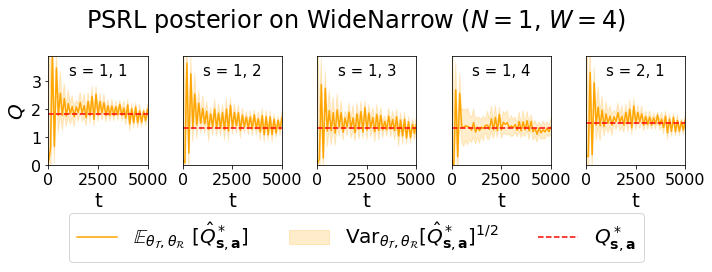

In [191]:
fig = plt.figure(figsize=(10, 3.8))

color = 'orange'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}~[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')

        plt.ylim([0, 3.9])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2500, 5000])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
            plt.yticks([0, 1, 2, 3])
        
        plt.gca().text(2500, 3.2, r's = {}, {}'.format(s + 1, a + 1),
                       fontsize=15, horizontalalignment='center')
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('PSRL posterior on WideNarrow ($N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.8, bottom=0.4)
plt.savefig(save_loc + 'psrl-posterior-accuracy-widenarrow-4.pdf', bbox_inches='tight')
plt.show()

In [100]:
means = []

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_ = load_agent(environment, PSRLAgent(agent_params), seed=0, episode=0, frame=4000)


for i in range(1000):
    P, R = agent_.sample_posterior()
    pi, Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=50)
    means.append(Q_)
    
means = np.array(means)

(0.5, 3)

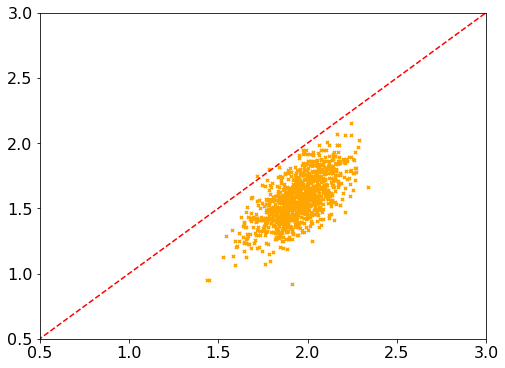

In [306]:
plt.scatter(means[:, 0, 0], means[:, 0, 1], color='orange', marker='x', s=10)
plt.plot(np.linspace(0, 3), np.linspace(0, 3), '--', color='red')
plt.xlim([0.5, 3])
plt.ylim([0.5, 3])

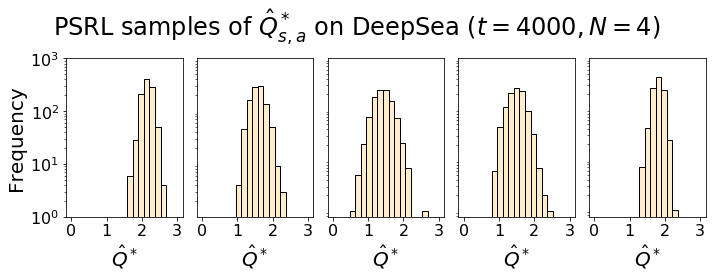

In [268]:
fig = plt.figure(figsize=(10, 4))


for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        plt.hist(means[:, s, a],
                 facecolor="orange",
                 alpha=0.2,
                 log=True,
                 bins=np.linspace(0, 3.0, 20))
        
        plt.hist(means[:, s, a],
                 facecolor="None",
                 edgecolor='k',
                 bins=np.linspace(0, 3.0, 20))
        
        plt.xticks([0.0, 1.0, 2.0, 3.0])
        plt.yticks([1e0, 1e1, 1e2, 1e3])
        
        if s == 0 and a == 0:
            plt.ylabel('Frequency', fontsize=20)
        else:
            plt.yticks([])
        
        plt.xlabel('$\hat{Q}^*$', fontsize=20)
        
        plt.tight_layout()
        
fig.suptitle('PSRL samples of $\hat{Q}^*_{s, a}$ on DeepSea ($t = 4000, N = 4$)', fontsize=24)
fig.subplots_adjust(top=0.8, bottom=0.25)
# plt.savefig(save_loc + 'psrl-q-samples-deepsea-4000.pdf', bbox_inches='tight')
plt.show()

In [144]:
kappa = np.array([1., 1., 100., 10000.])

samples = np.random.dirichlet(kappa, size=100000)
(samples.var(axis=0) / samples.mean(axis=0)).sum() * 100 * 10

0.29988782926461627

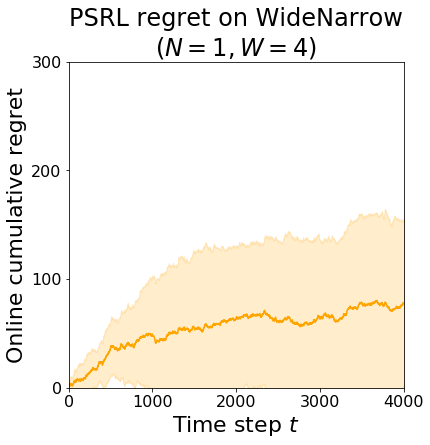

In [186]:
color = 'orange'

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = PSRLAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=max_frames)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=max_frames)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('PSRL regret on WideNarrow\n($N = 1, W = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'psrl-cumulative-regret-widenarrow-4.pdf', bbox_inches='tight')
plt.show()

# UBE

In [102]:
# for N in tqdm([1]):
#     for W in tqdm([4]):
#         for seed in tqdm(range(5)):
#             # Environment constants
#             rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
#             env_params = {'N'          : N,
#                           'W'          : W,
#                           'episodic'   : False,
#                           'rew_params' : rew_params}

#             # Define environment
#             environment = WideNarrow(env_params)
#             environment.reset()

#             # Agent constants
#             agent_params = {'gamma'            : 0.9,
#                             'kappa'            : 1.0,
#                             'mu0'              : 0.0,
#                             'lamda'            : 1.0,
#                             'alpha'            : 2.0,
#                             'beta'             : 2.0,
#                             'Rmax'             : 2.0,
#                             'num_pi_iter'      : 40,
#                             'T'                : float('inf'),
#                             'zeta'             : 0.1,
#                             'num_dyn_samples'  : 100,
#                             'sa_list'          : environment.sa_list()}


#             # Define agent
#             agent = UbeNoUnrollAgent(agent_params)

#             # Run experiment
#             agent_copies = run_experiment(environment,
#                                           agent,
#                                           seed=seed,
#                                           num_episodes=1,
#                                           num_frames_per_episode=max_frames+1,
#                                           num_offline_frames=10,
#                                           num_oracle_iter=100,
#                                           max_buffer_length=3,
#                                           save_every=save_every)

In [192]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [193]:
means, stds = [], []

rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, max_frames+1, save_every):
    
    agent_ = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0, episode=0, frame=frame)
            
    means.append(agent_.Qmu)
    stds.append(agent_.Qvar**0.5)
            
means = np.array(means)
stds = np.array(stds)

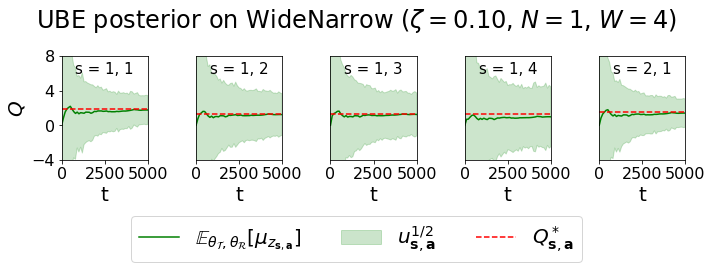

In [195]:
fig = plt.figure(figsize=(10, 3.8))

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z_{\mathbf{s}, \mathbf{a}}}]$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']

leg = [None] * 3

s, a = 0, 0

for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
        
        plt.ylim([-4, 8])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2500, 5000])
        plt.xlabel('t', fontsize=20)
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
            plt.yticks([-4, 0, 4, 8])
        
        plt.gca().text(2500, 6, r's = {}, {}'.format(s + 1, a + 1),
                       fontsize=15, horizontalalignment='center')   
        plt.xlabel('t', fontsize=20)      
            
            
fig.suptitle('UBE posterior on WideNarrow ($\zeta = 0.10$, $N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.8, bottom=0.42)
plt.savefig(save_loc + 'ube-posterior-accuracy-widenarrow-4-0_10.pdf', bbox_inches='tight')
plt.show()

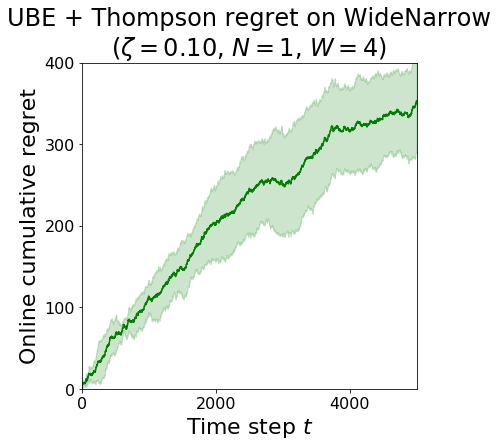

In [110]:
color = 'green'

rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(5):
    
    # Define agent
    agent = UbeNoUnrollAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=max_frames)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=max_frames)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE + Thompson regret on WideNarrow\n($\zeta = 0.10$, $N = 1$, $W = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, max_frames])
plt.gca().set_ylim(bottom=0, top=400)
plt.savefig(save_loc + 'ube-cumulative-regret-deepsea-4-0_10.pdf', bbox_inches='tight')
plt.show()

# MM Variance bonuus

In [111]:
# for N in tqdm([1]):
#     for W in tqdm([4]):
#         for seed in tqdm(range(5)):

#             rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
#             env_params = {'N'          : N,
#                           'W'          : W,
#                           'episodic'   : False,
#                           'rew_params' : rew_params}

#             # Define environment
#             environment = WideNarrow(env_params)
#             environment.reset()

#             # Agent constants
#             agent_params = {'gamma'            : 0.9,
#                             'kappa'            : 1.0,
#                             'mu0'              : 0.0,
#                             'lamda'            : 1.0,
#                             'alpha'            : 2.0,
#                             'beta'             : 2.0,
#                             'num_PI_steps'     : 40,
#                             'T'                : float('inf'),
#                             'zeta'             : 1.0,
#                             'thompson'         : False,
#                             'num_dyn_samples'  : 100, 
#                             'sa_list'          : environment.sa_list()}

#             # Define agent
#             agent = MomentMatchingAgent(agent_params)

#             # Run experiment
#             agent_copies = run_experiment(environment,
#                                           agent,
#                                           seed=seed,
#                                           num_episodes=1,
#                                           num_frames_per_episode=max_frames,
#                                           num_offline_frames=100,
#                                           num_oracle_iter=40,
#                                           max_buffer_length=3,
#                                           save_every=save_every)

In [157]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [166]:
means, stds = [], []

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : False,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, max_frames+1, save_every):
    
    agent_ = load_agent(environment, MomentMatchingAgent(agent_params), seed=3, episode=0, frame=frame)
            
    means.append(agent_.mu_z_sa)
    stds.append(agent_.val_var_val)
            
means = np.array(means)
stds = np.array(stds)

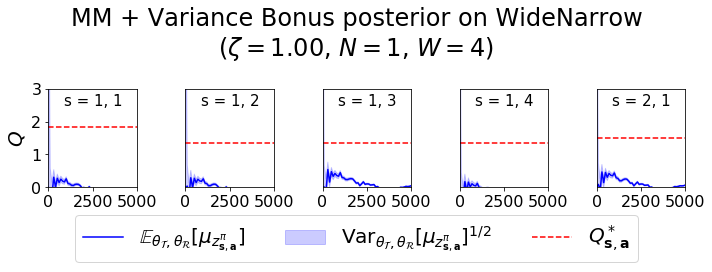

In [167]:
fig = plt.figure(figsize=(10, 3.8))
subsample = 20

color = 'blue'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^\pi_{\mathbf{s}, \mathbf{a}}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^\pi_{\mathbf{s}, \mathbf{a}}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([0, 3])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2500, 5000])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
            plt.yticks([0, 1, 2, 3])
        
        plt.gca().text(2500, 2.5, r's = {}, {}'.format(s + 1, a + 1),
                       fontsize=15, horizontalalignment='center')         
            
fig.suptitle('MM + Variance Bonus posterior on WideNarrow\n($\zeta = 1.00$, $N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.68, bottom=0.32)
plt.savefig(save_loc + 'mm-ucb-posterior-accuracy-widenarrow-4-1_00.pdf', bbox_inches='tight')
plt.show()

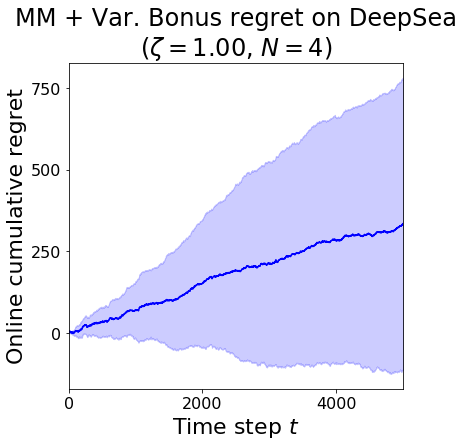

In [161]:
color = 'blue'

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : False,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(5):
    
    # Define agent
    agent = MomentMatchingAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=max_frames)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=max_frames)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('MM + Var. Bonus regret on DeepSea\n($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 5000])
# plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'mm-ucb-cumulative-regret-deepsea-4-1_00.pdf', bbox_inches='tight')
plt.show()

# MM Thompson

In [116]:
# for N in tqdm([1]):
#     for W in tqdm([4]):
#         for seed in tqdm(range(5)):

#             # Environment constants
#             rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
#             env_params = {'N'          : N,
#                           'W'          : W,
#                           'episodic'   : False,
#                           'rew_params' : rew_params}

#             # Define environment
#             environment = WideNarrow(env_params)
#             environment.reset()

#             # Agent constants
#             agent_params = {'gamma'            : 0.9,
#                             'kappa'            : 1.0,
#                             'mu0'              : 0.0,
#                             'lamda'            : 1.0,
#                             'alpha'            : 2.0,
#                             'beta'             : 2.0,
#                             'num_PI_steps'     : 40,
#                             'T'                : float('inf'),
#                             'zeta'             : 1.0,
#                             'thompson'         : True,
#                             'num_dyn_samples'  : 100, 
#                             'sa_list'          : environment.sa_list()}

#             # Define agent
#             agent = MomentMatchingAgent(agent_params)

#             # Run experiment
#             agent_copies = run_experiment(environment,
#                                           agent,
#                                           seed=seed,
#                                           num_episodes=1,
#                                           num_frames_per_episode=max_frames+1,
#                                           num_offline_frames=100,
#                                           num_oracle_iter=40,
#                                           max_buffer_length=3,
#                                           save_every=save_every)

In [197]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [198]:
means, stds = [], []

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : True,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, max_frames+1, save_every):
    
    agent_ = load_agent(environment, MomentMatchingAgent(agent_params), seed=0, episode=0, frame=frame)
            
    means.append(agent_.mu_z_sa)
    stds.append(agent_.val_var_val**0.5)
            
means = np.array(means)
stds = np.array(stds)

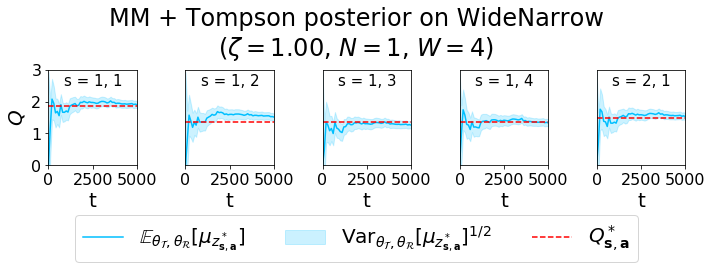

In [200]:
fig = plt.figure(figsize=(10, 3.8))

color = 'deepskyblue'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^*_{\mathbf{s}, \mathbf{a}}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^*_{\mathbf{s}, \mathbf{a}}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W + 1):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W + 1, n * (W + 1) + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([0, 3])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2500, 5000])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
            plt.yticks([0, 1, 2, 3])
        
        plt.gca().text(2500, 2.5, r's = {}, {}'.format(s + 1, a + 1),
                       fontsize=15, horizontalalignment='center')   
        plt.xlabel('t', fontsize=20)      
            
            
fig.suptitle('MM + Tompson posterior on WideNarrow\n($\zeta = 1.00$, $N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.75, bottom=0.4)
plt.savefig(save_loc + 'mm-thompson-posterior-accuracy-widenarrow-4-1_00.pdf', bbox_inches='tight')
plt.show()

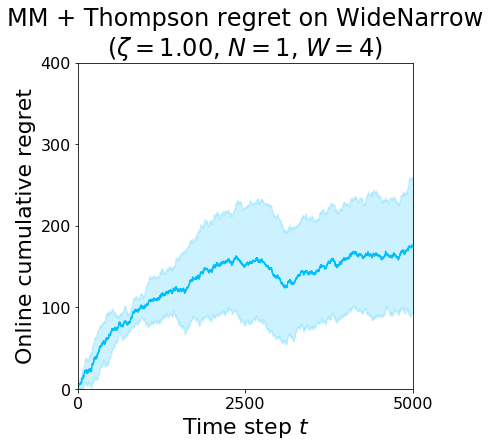

In [139]:
color = 'deepskyblue'

# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : True,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(5):
    
    # Define agent
    agent = MomentMatchingAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=max_frames)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=max_frames)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('MM + Thompson regret on WideNarrow\n($\zeta = 1.00$, $N = 1$, $W = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, max_frames])
plt.xticks([0, 2500, 5000])
plt.gca().set_ylim(bottom=0, top=400)
plt.savefig(save_loc + 'mm-thompson-cumulative-regret-widenarrow-4.pdf', bbox_inches='tight')
plt.show()

In [37]:
# Environment constants
rew_params = ((0, 1e0), (0.5, 1e0), (0, 1e0))
env_params = {'N'          : N,
              'W'          : W,
              'episodic'   : False,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : True,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

agent = MomentMatchingAgent(agent_params)
agent = load_agent(environment, agent, seed=seed, episode=0, frame=1000)

agent